# Prediction of customers' travel pattern

- Build classifier that predicts the conversion-likelihood of a user

# Content

- Loading saved data, working with additional time series variables.
- data exploration i.e comparison of online events of "booking" vs "search" occuring over time.
- Origin and Destination airport data exploration wrt booking and search activities.
- Checking airports and most frequent origins and destinations
- Data process i.e duplicate values in data, outliers,correlation between variables, encoding categorical variables
- Selection of key features for analysis and predictive model.


# 1)-Importing key modules

In [1]:
# To avoid warnings Message 
import warnings
warnings.filterwarnings('ignore')
# For processing
import pandas as pd
import numpy as np
import scipy
import datetime as dt
from datetime import date
import datetime as dt
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# 2)-Loading data

In [2]:
df_travel = pd.read_csv('travel_data.csv')
df_travel.shape

(47007, 8)

In [3]:
df_travel.columns

Index(['event_type', 'user_id', 'origin', 'destination', 'distance',
       'num_family', 'ts_datetime', 'len_jour'],
      dtype='object')

In [4]:
df_travel.head()

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0
2,book,f953f0,BER,CGN,469.781624,2,2017-04-27 23:03:43,3.0
3,book,794d35,BER,BCN,1498.817537,1,2017-04-27 15:17:50,3.0
4,book,ca4f94,DEL,BKK,2921.339028,4,2017-04-27 22:51:57,6.0


In [5]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object
ts_datetime,object


In [6]:
df_travel["ts_datetime"]=pd.to_datetime(df_travel.ts_datetime)

In [7]:
table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
ts_datetime,datetime64[ns]
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object


# 1)-working with ts_datetime

In [8]:
df_travel['ts_year']=df_travel.ts_datetime.dt.year
df_travel['ts_month']=df_travel.ts_datetime.dt.month
df_travel['ts_day']=df_travel.ts_datetime.dt.day
df_travel['ts_dayofweek']=df_travel.ts_datetime.dt.dayofweek
df_travel['ts_hour']=df_travel.ts_datetime.dt.hour

In [9]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [10]:
df_travel.ts_year.unique()

array([2017])

We only have one year so, we wont be able to get any useful analysism

In [11]:
df_travel.ts_month.unique()

array([4, 5])

**Both month and year will not provide much of longitudnal(time related) information. Only we can see how much booking occured in month of April vs month of May**

In [12]:
len(df_travel[df_travel['ts_month']==4])

42512

In [13]:
len(df_travel[df_travel['ts_month']==5])

4495

In [14]:
df_travel.groupby(df_travel.ts_month).size()

ts_month
4    42512
5     4495
dtype: int64

Perhaps we do not have full month data for May. That is why we have very few samples

In [15]:
dist=df_travel.ts_month.value_counts(ascending=True).sort_index()

### 1.1)- Plotting travel pattern

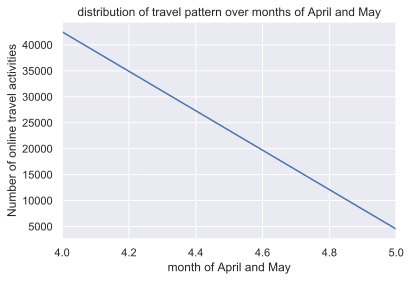

In [16]:
dist.plot()
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

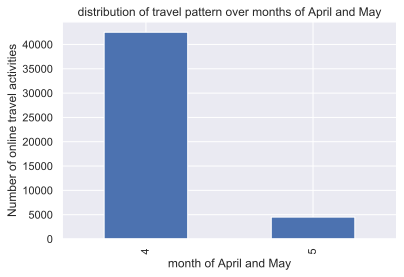

In [17]:
dist.plot(kind="bar")
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

We have not got very useful information there. There is no lineplot that I am used to see for time series.

**Let's try other time values in terms of hours**

In [18]:
dist2=df_travel.ts_hour.value_counts(ascending=True).sort_index()
dist2

0     3506
1     3009
2     1841
3      918
4      468
5      232
6      124
7       98
8      131
9      294
10     655
11    1240
12    1973
13    2557
14    2758
15    2803
16    2870
17    3059
18    2876
19    2879
20    3053
21    3127
22    3124
23    3412
Name: ts_hour, dtype: int64

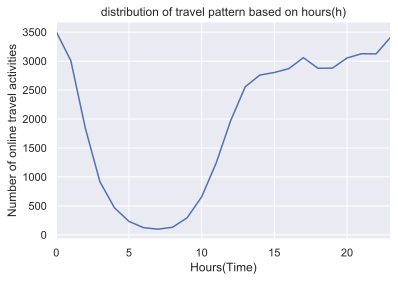

In [19]:
dist2.plot()
plt.xlabel('Hours(Time)')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern based on hours(h)')
#plt.legend()
plt.show()

We can observe from plot that during morning time i.e 5-10 , there is not much happening. Plot reached its lowest

As we move in working hours , there are more activities. High point approaches after 20:00 i.e 8 pm. This does provide information about peak and low for online activities. 

It also depends if there is dynamic pricing is in place due to which activities are changing ?

### 1.2)- How does "book" vs "search" go?

In [20]:
t=df_travel

In [21]:
t=t.groupby(["ts_hour","event_type"]).size()
t=t.unstack("event_type")
t

event_type,book,search
ts_hour,,
0,143,3363
1,131,2878
2,88,1753
3,30,888
4,15,453
5,8,224
6,3,121
7,2,96
8,4,127


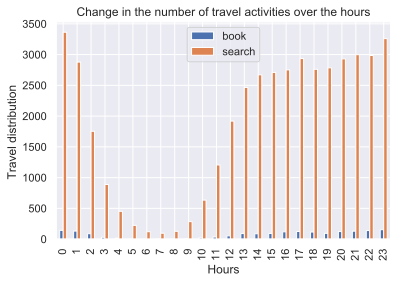

In [22]:
t.plot(kind="bar")
plt.xlabel('Hours')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the hours')
plt.legend()
plt.show()

**Alternative way**

In [23]:
f=df_travel

In [24]:
f=f.groupby(f.ts_hour).event_type.value_counts()

In [25]:
f=f.unstack("event_type")
f

event_type,book,search
ts_hour,,
0,143,3363
1,131,2878
2,88,1753
3,30,888
4,15,453
5,8,224
6,3,121
7,2,96
8,4,127


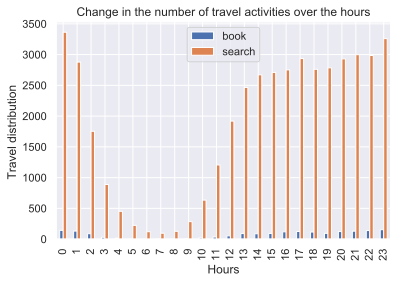

In [26]:
f.plot(kind="bar")
plt.xlabel('Hours')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the hours')
plt.legend()
plt.show()

### 1.3)- By percentage

In [27]:
k=df_travel
k=k.groupby(k.ts_hour).event_type.value_counts(normalize=True)
k=k.unstack("event_type")
k

event_type,book,search
ts_hour,,
0,0.040787,0.959213
1,0.043536,0.956464
2,0.047800,0.952200
3,0.032680,0.967320
4,0.032051,0.967949
5,0.034483,0.965517
6,0.024194,0.975806
7,0.020408,0.979592
8,0.030534,0.969466


One thing is for sure, we can see more activities in search whereas booking activities are way too low. I was expecting this. It makes sense to have more online search activities than booking ones. But, this difference is huge. For example, take a look at figures. Most of search activities are 95% or more and maximum booking activities are 4% even at highest level.

There is no exceptional. Even on peak online activity period, we cannot find a jump in booking activities.

### 1.4)- Activities over days of month

In [28]:
q=df_travel

In [29]:
q=q.groupby(["ts_day","event_type"]).size()
q=q.unstack("event_type")
q

event_type,book,search
ts_day,,
1,124,3391
2,38,942
18,90,490
19,121,580
20,103,509
21,151,738
22,128,688
23,133,5787
24,129,3332


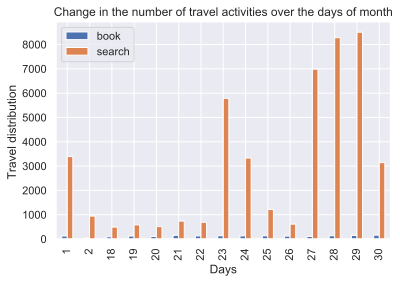

In [30]:
q.plot(kind="bar")
plt.xlabel('Days')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the days of month')
plt.legend()
plt.show()

### 1.5)- Activities over days of week

In [31]:
w=df_travel

In [32]:
w=w.groupby(["ts_dayofweek","event_type"]).size()
w=w.unstack("event_type")
w

event_type,book,search
ts_dayofweek,,
0,253,6723
1,258,2648
2,241,1191
3,208,7496
4,284,9018
5,273,9193
6,292,8929


Increase in search and booking is evident from Day 4-Day 6 i.e Friday-Sunday.

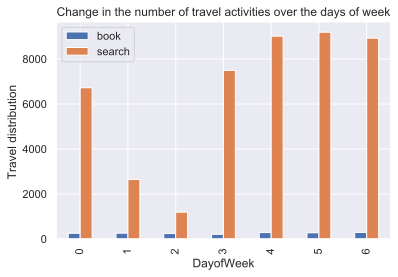

In [33]:
w.plot(kind="bar")
plt.xlabel('DayofWeek')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the days of week')
plt.legend()
plt.show()

In [34]:
# lets try line plot
dayofweek=df_travel["ts_dayofweek"].sort_values()
k=df_travel.groupby(dayofweek)['event_type'].value_counts()

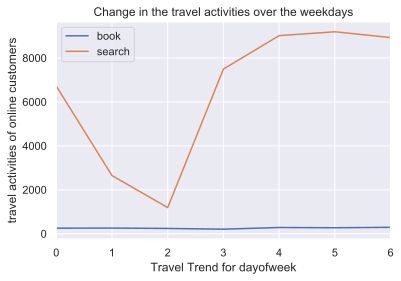

In [35]:
k=k.unstack('event_type')
k.plot()
plt.xlabel('Travel Trend for dayofweek')
plt.ylabel('travel activities of online customers')
plt.title('Change in the travel activities over the weekdays')
plt.legend()
plt.show()

Line plot has not given us much new information compared to bar plot. But we can see that there is trend fluctuation in search pattern which reaches its peak at end of weekend whereas booking trend has a linear behavior but, very low activities as we discussed above in hours trend.There is no sharp fall in booking activities like searches results rather a smooth and consistent increase over the weekend starting with lower point(253) and ending with higher(292). 

In comparison, we see more interesting high point in searching results i.e lower on Wednesday (1191) and peak on Friday(9018) and Saturday(9193).

### 1.7)- Origin and Destination

Checking what is balance of search and booking on origin and destination airports

In [36]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [37]:
# Most busy origin airport
from collections import Counter
Counter(df_travel.origin)

Counter({'PAR': 6010,
         'FRA': 5813,
         'BER': 3501,
         'DEL': 30,
         'SXF': 254,
         'HAM': 3699,
         'DUS': 4470,
         'DLC': 6,
         'OSL': 26,
         'ORY': 966,
         'CPH': 50,
         'STR': 2684,
         'IZM': 39,
         'AMS': 450,
         'BKK': 165,
         'MOW': 82,
         'NCE': 721,
         'MUC': 4638,
         'LYS': 1560,
         'AGP': 80,
         'PTY': 9,
         'BUH': 42,
         'CGN': 2197,
         'TLS': 985,
         'BOM': 12,
         'CDG': 1306,
         'TXL': 690,
         'SAW': 48,
         'PRG': 84,
         'LON': 162,
         'CHI': 38,
         'SGN': 32,
         'HEL': 21,
         'IST': 169,
         'JFK': 34,
         'NYC': 125,
         'DUB': 52,
         'HAN': 39,
         'MIL': 84,
         'SIN': 108,
         'YEA': 4,
         'ADB': 21,
         'TLV': 73,
         'ATH': 76,
         'SHA': 26,
         'ZRH': 448,
         'ROM': 75,
         'MRS': 896,
         '

In [38]:
Counter(df_travel.destination)

Counter({'NYC': 909,
         'WAS': 67,
         'CGN': 451,
         'BCN': 1513,
         'BKK': 1191,
         'SCL': 49,
         'VIE': 680,
         'ARN': 119,
         'PMI': 2110,
         'LGW': 63,
         'OPO': 1001,
         'ATL': 78,
         'CHI': 68,
         'ATH': 839,
         'BJS': 55,
         'MCO': 66,
         'MUC': 966,
         'MNL': 218,
         'FRA': 681,
         'HNL': 137,
         'YMQ': 282,
         'DXB': 488,
         'HKT': 366,
         'BUE': 67,
         'STR': 491,
         'VCE': 543,
         'NCE': 567,
         'LON': 1101,
         'OSA': 58,
         'IST': 1762,
         'AKL': 114,
         'LIS': 1607,
         'STN': 96,
         'BER': 1468,
         'WAW': 232,
         'MEX': 101,
         'BOS': 84,
         'MOW': 356,
         'IEV': 115,
         'ZRH': 314,
         'GVA': 228,
         'DUS': 772,
         'TYO': 240,
         'AYT': 779,
         'PAR': 1197,
         'LHR': 254,
         'TXL': 322,
         'BUD':

**origin airport vs event_type**

In [39]:
j=df_travel

In [40]:
origin=j.groupby(j.origin).event_type.value_counts(sort=True)
df_origin=pd.DataFrame(origin)
df_origin

event_type
origin event_type            
ABV    search               4
ADB    search              21
ADL    search               3
       book                 1
AER    search               2
...                       ...
YYC    search               9
       book                 1
YYZ    search               6
ZRH    search             430
       book                18

[348 rows x 1 columns]

In [41]:
# for destination 
dest=j.groupby(j.destination).event_type.value_counts(sort=True)
df_dest=pd.DataFrame(dest)
df_dest

event_type
destination event_type            
ABV         search               8
ADB         search             118
            book                 6
ADD         search              39
ADL         search              14
...                            ...
YYC         search              51
            book                 1
YYZ         search              45
ZRH         search             293
            book                21

[445 rows x 1 columns]

This is useful information. But, it is overwhelming. Finding a query for checking specific airport destination

In [42]:
df_nyc=j.groupby([j["destination"]=="NYC"]).event_type.value_counts(sort=True)

In [43]:
nyc=pd.DataFrame(df_nyc)
nyc

event_type
destination event_type            
False       search           44309
            book              1789
True        search             889
            book                20

For Destnation, we have 889 search and 20 booking event at NYC airport

**checking multi-indexing w.r.t destination, hours per day, and event type count**

In [44]:
g=df_travel

In [45]:
g=g.groupby(["destination","ts_hour"]).event_type.value_counts()

In [46]:
df_dest2=pd.DataFrame(g)
df_dest2.head(10)

event_type
destination ts_hour event_type            
ABV         0       search               1
            4       search               2
            14      search               1
            16      search               3
            20      search               1
ADB         0       search               8
            1       search              11
            2       search               6
            3       search               9
            4       search               3

- Fourth column is actually count of activities for hourly activity
This shows change in activties through different hours at ABV airport. All activities are "search" in ABV case and their count is give as per hours of day.

In [47]:
df_dest2.tail(10)

event_type
destination ts_hour event_type            
ZRH         19      search              23
                    book                 1
            20      search              27
                    book                 2
            21      search              17
                    book                 1
            22      search              24
                    book                 3
            23      search              26
                    book                 1

This gives better information

- This table shows activities occured for ZRH airport destination. At hour 19 i.e 7 pm, we get 23 search queries and 1 booking occured. These kind of tables can help us in viewing how frequent customer choose "ZRH" as their destination and how often they "search" vs "book" for this very destination.

### 1.8)- Checking airports and most frequent origins and destinations

In [49]:
# use count vector for names of airports name. 

from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()

In [50]:
cvec.fit(df_travel['origin'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [51]:
len(cvec.get_feature_names())

236

As count is 236 so, we cannot check one by one. We will see most important or most frequent.

In [52]:
zero_doc_matrix = cvec.transform(df_travel[df_travel['event_type'] == "search"].origin) 
one_doc_matrix = cvec.transform(df_travel[df_travel['event_type'] == "book"].origin) 

In [53]:
import numpy as np
zero_tf = np.sum(zero_doc_matrix,axis=0)
one_tf = np.sum(one_doc_matrix,axis=0)

In [54]:
search = np.squeeze(np.asarray(zero_tf))
book = np.squeeze(np.asarray(one_tf))

In [55]:
term_freq_df = pd.DataFrame([search,book],columns=cvec.get_feature_names())

In [56]:
term_freq_df.head()

,abv,adb,adl,aer,agp,akl,ala,alc,alg,ams,...,yea,ymq,yow,yto,yul,yvr,ywg,yyc,yyz,zrh
0,4,21,3,2,75,17,4,52,31,435,...,3,40,2,24,13,24,1,9,6,430
1,0,0,1,0,5,1,0,3,1,15,...,1,1,0,1,0,0,0,1,0,18


In [57]:
term_freq_df=term_freq_df.transpose()
term_freq_df.tail(5)

,0,1
yvr,24,0
ywg,1,0
yyc,9,1
yyz,6,0
zrh,430,18


In [58]:
term_freq_df.columns = ['search', 'book']
term_freq_df['total'] = term_freq_df['search'] + term_freq_df['book']
term_freq_df.head()

,search,book,total
abv,4,0,4
adb,21,0,21
adl,3,1,4
aer,2,0,2
agp,75,5,80


**Top 25 airports origins as per travel activties**

In [59]:
term_freq_df.sort_values(by='total', ascending=False).head(25)

,search,book,total
par,5868,142,6010
fra,5626,187,5813
muc,4410,228,4638
dus,4258,212,4470
ham,3516,183,3699
ber,3308,193,3501
str,2571,113,2684
cgn,2103,94,2197
lys,1532,28,1560
cdg,1287,19,1306


Text(0.5, 1.0, 'Top 25 Origin Airports for searching activity')

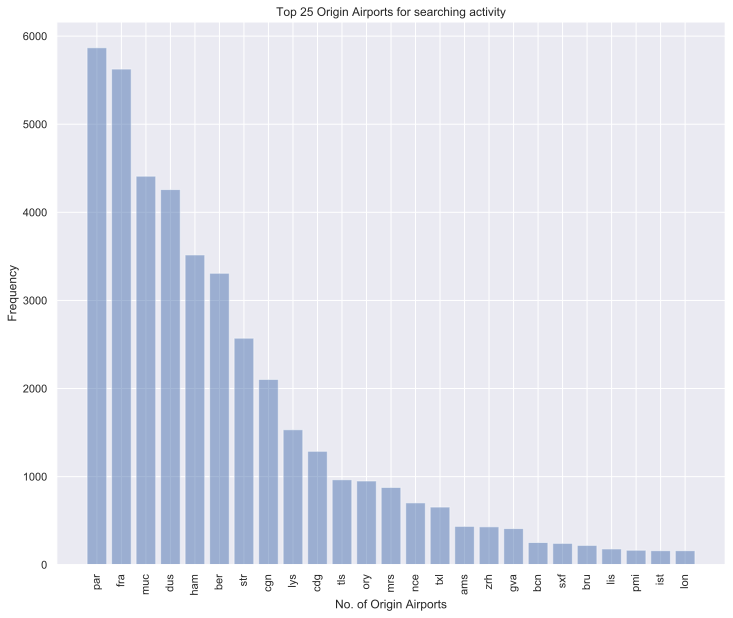

In [60]:
y_one = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_one, term_freq_df.sort_values(by='search', ascending=False)['search'][:25], align='center', alpha=0.5)
plt.xticks(y_one, term_freq_df.sort_values(by='search', ascending=False)['search'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('No. of Origin Airports')
plt.title('Top 25 Origin Airports for searching activity')

This is interesting. It is not a prediction rather a descriptive analysis. We can see a trend that Paris, Frankfurt, Munich, Düsseldorf, Hamburg are in most frequent airports i.e Germans love to search. But, do they like to book? Let's see.

Text(0.5, 1.0, 'Top 25 Origin Airports for booking activity')

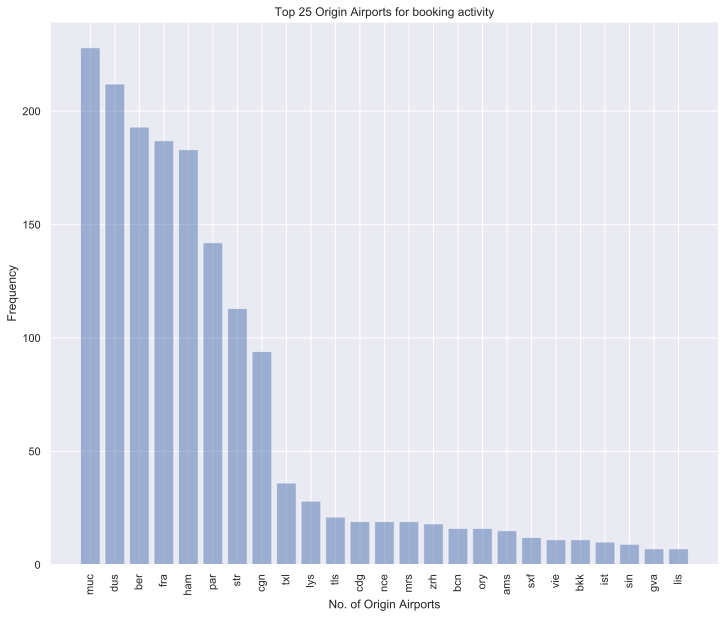

In [61]:
y_one = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_one, term_freq_df.sort_values(by='book', ascending=False)['book'][:25], align='center', alpha=0.5)
plt.xticks(y_one, term_freq_df.sort_values(by='book', ascending=False)['book'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('No. of Origin Airports')
plt.title('Top 25 Origin Airports for booking activity')

Paris was high in searching but, comes after 4 German airports. So, people having origin from Germany like to search and also book.

On more serious note, these top 25 search and booking activties tell us that airport origin matters as it gives information about customers. The information such as time of booking (i.e peak hours) , number of family members, and similarly their origin matters. Airport preferences can be seen from this variable. So, we shall not drop this important variable for our analysis.

#### frequent destinations Airports

In [62]:
cvec.fit(df_travel['destination'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [63]:
len(cvec.get_feature_names())

276

In [64]:
zero_doc_matrix = cvec.transform(df_travel[df_travel['event_type'] == "search"].destination) 
one_doc_matrix = cvec.transform(df_travel[df_travel['event_type'] == "book"].destination) 

In [65]:
import numpy as np
zero_tf = np.sum(zero_doc_matrix,axis=0)
one_tf = np.sum(one_doc_matrix,axis=0)
search = np.squeeze(np.asarray(zero_tf))
book = np.squeeze(np.asarray(one_tf))

In [66]:
term_freq_df2 = pd.DataFrame([search,book],columns=cvec.get_feature_names())

In [67]:
term_freq_df2=term_freq_df2.transpose()

In [68]:
term_freq_df2.columns = ['search', 'book']
term_freq_df2['total'] = term_freq_df2['search'] + term_freq_df2['book']
term_freq_df2.head()

,search,book,total
abv,8,0,8
adb,118,6,124
add,39,0,39
adl,14,1,15
aer,20,1,21


**top 25 destination airports**

In [69]:
term_freq_df2.sort_values(by='total', ascending=False).head(25)

,search,book,total
pmi,2035,75,2110
ist,1704,58,1762
lis,1550,57,1607
bcn,1449,64,1513
ber,1362,106,1468
par,1154,43,1197
bkk,1147,44,1191
lon,1048,53,1101
opo,973,28,1001
muc,911,55,966


Text(0.5, 1.0, 'Top 25 Destination Airpoorts for searching activity')

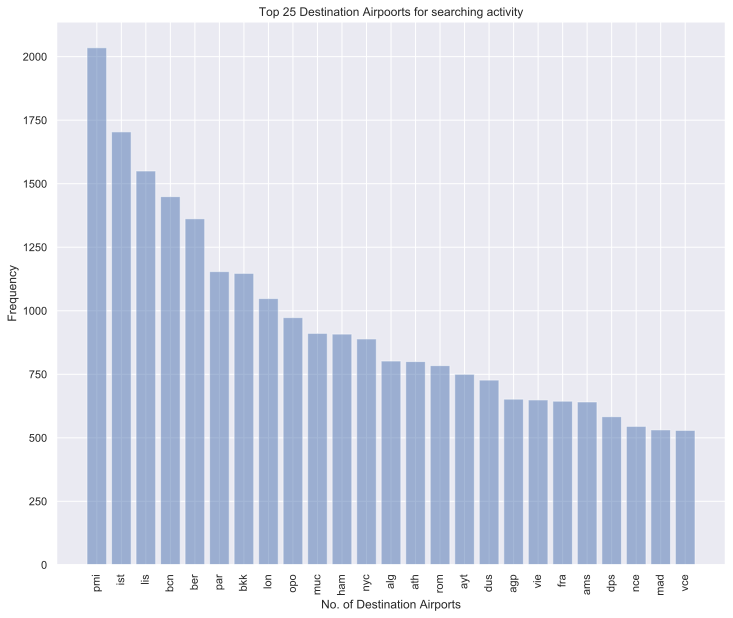

In [70]:
y_one = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_one, term_freq_df2.sort_values(by='search', ascending=False)['search'][:25], align='center', alpha=0.5)
plt.xticks(y_one, term_freq_df2.sort_values(by='search', ascending=False)['search'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('No. of Destination Airports')
plt.title('Top 25 Destination Airpoorts for searching activity')

Palma de Mallorca , Istanbul , Lisbon , Barcelona , and Berlin are top searched destination. Perhaps Germans are not very good hosts :p <br>
For a serious note, it can be understood that most desireable destinations are different from most "travelled from" airports. It makes sense. Let's see how booking pattern goes !

Text(0.5, 1.0, 'Top 25 Origin Destination for booking activity')

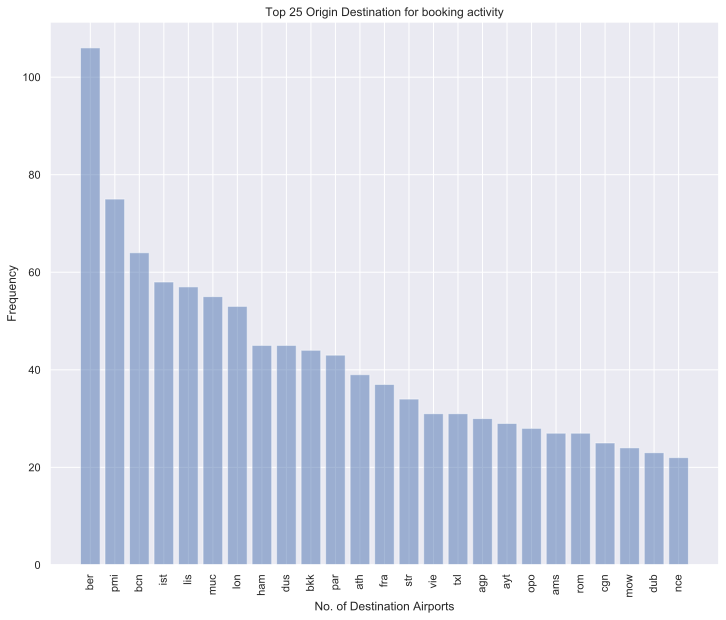

In [71]:
y_one = np.arange(25)
plt.figure(figsize=(12,10))
plt.bar(y_one, term_freq_df2.sort_values(by='book', ascending=False)['book'][:25], align='center', alpha=0.5)
plt.xticks(y_one, term_freq_df2.sort_values(by='book', ascending=False)['book'][:25].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('No. of Destination Airports')
plt.title('Top 25 Origin Destination for booking activity')

Again Germany airport is on top. Can we say that people search for so many different airport destinations but, they actually choose Berlins for their booking. :)
    
Again being serious, Palma de Mallorca , Istanbul , Lisbon , Barcelona are not far. 

Our analysis shows that origin and destination matters and may give some very intersting knowhow about customers travel pattern and their conversion rate. We shall use both of these categorical variables for our analysis and predictive model.

**we plot, search frequency on X-axis, and booking frequency on Y-axis**

Text(0.5, 1.0, 'Searching Frequency vs Booking Frequency')

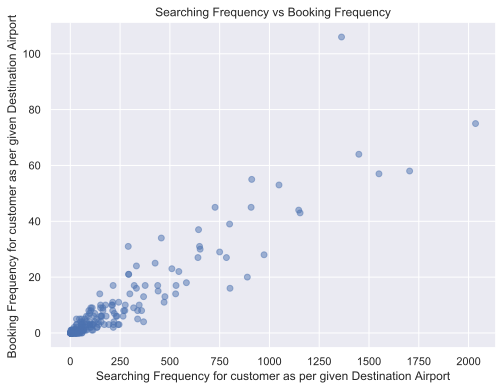

In [72]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="search", y="book",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Booking Frequency for customer as per given Destination Airport ')
plt.xlabel('Searching Frequency for customer as per given Destination Airport')
plt.title('Searching Frequency vs Booking Frequency')

Most of the words are below 10 on both X-axis and Y-axis, and we cannot see a meaningful relation between search and booking frequency.

In order to come up with a meaningful metric which can characterise important tokens in each class, I borrowed a metric presented by Jason Kessler in PyData 2017 Seattle. In this presentation, he presented a Python library called Scattertext. Even though I did not make use of the library, the metrics used in the Scattertext as a way of visualising text data are very useful in filtering meaningful tokens from the frequency data. Intuitively, if a word(airport code in our case) appears more often in one class compared to another(booking vs search in our case), this can be a good measure of how much the word is meaningful to characterise the class. In the code below, I named it as 'booking_rate' and 'search_rate',

**booking_rate=(booking frequency/booking frequency+search frequency)**

**search_rate=(search frequency/search frequency+booking frequency)**

In [73]:
term_freq_df2['search_rate'] = term_freq_df2['search'] * 1./term_freq_df2['total']
term_freq_df2['booking_rate'] = term_freq_df2['book'] * 1./term_freq_df2['total']

In [74]:
term_freq_df2.head()

,search,book,total,search_rate,booking_rate
abv,8,0,8,1.000000,0.000000
adb,118,6,124,0.951613,0.048387
add,39,0,39,1.000000,0.000000
adl,14,1,15,0.933333,0.066667
aer,20,1,21,0.952381,0.047619


With these measurements, we can also observe frequency of online activities as per airport destination.

again, this result is aligned with above search vs booking activities we observed. Booking rate is way too low in comparison to search rate for airports.

### Summary Table

In [75]:
pd.crosstab(df_travel['event_type'], df_travel['destination'],margins=True)

destination,ABV,ADB,ADD,ADL,AER,AGP,AKL,ALA,ALC,ALG,...,YMQ,YOW,YTO,YUL,YVR,YWG,YYC,YYZ,ZRH,All
event_type,,,,,,,,,,,,,,,,,,,,,
book,0,6,0,1,1,30,3,5,13,16,...,8,0,1,1,2,0,1,0,21,1809
search,8,118,39,14,20,652,111,46,368,802,...,274,16,114,76,133,16,51,45,293,45198
All,8,124,39,15,21,682,114,51,381,818,...,282,16,115,77,135,16,52,45,314,47007


I think we have enough information about origin & destination vs event_type. Let's move along !

# 4)- Checking duplicates


In [76]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [77]:
dup=df_travel

In [78]:
dup.shape

(47007, 13)

In [79]:
dup.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [80]:
dup.duplicated().sum()

1202

In [81]:
dup.loc[dup.duplicated(), :]

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
152,search,6600e0,FRA,IST,1864.628098,2,2017-04-27 22:39:53,15.0,2017,4,27,3,22
396,search,d84b7f,SIN,DPS,1678.205760,2,2017-04-29 01:42:22,0.0,2017,4,29,5,1
397,search,fd49f2,DUS,ZRH,438.286394,2,2017-04-28 19:48:07,4.0,2017,4,28,4,19
433,search,98617f,STR,VIE,548.651726,2,2017-04-24 00:02:21,2.0,2017,4,24,0,0
481,search,078dff,TXL,PMI,1655.377060,1,2017-04-28 17:55:00,4.0,2017,4,28,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46492,search,b6a23c,PAR,VCE,843.229234,2,2017-04-27 20:10:49,2.0,2017,4,27,3,20
46513,search,acbd26,MUC,ATH,1495.104490,1,2017-04-27 04:58:27,8.0,2017,4,27,3,4
46515,search,11a1c2,AYT,STR,2188.445661,2,2017-04-27 13:09:30,0.0,2017,4,27,3,13
46730,search,842398,FRA,BKK,8961.256603,1,2017-04-24 13:07:22,20.0,2017,4,24,0,13


I am not in favor of removing values. But, this seems serious. If we have certain variable with duplicate value then I might think a repeating sample such user_id. Same user_id may occur for sure. 

But, this is for whole 13 columns. This must be fixed.

In [82]:
# using "keep" method in pandas

dup.drop_duplicates(keep="first").shape

(45805, 13)

Original dataset had 47007, 13 and we have now 45805, 13. We didnt lose too much data.

In [83]:
# make changes in our main dataset.

df_travel.drop_duplicates(keep="first", inplace=True)

In [84]:
df_travel.shape

(45805, 13)

In [85]:
df_travel[df_travel.user_id.duplicated()]

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
41,search,6b4d3b,PAR,MEX,9190.597504,2,2017-04-29 18:05:16,3.0,2017,4,29,5,18
66,book,75ce1b,DUS,BER,477.093351,2,2017-04-29 18:10:50,2.0,2017,4,29,5,18
70,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 21:37:51,11.0,2017,4,29,5,21
75,search,eec403,HAM,LHR,745.096782,1,2017-04-29 14:52:31,3.0,2017,4,29,5,14
78,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 13:08:04,2.0,2017,4,29,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46976,search,0ed3a6,CGN,MIL,621.460682,2,2017-04-24 22:15:46,5.0,2017,4,24,0,22
46977,search,2325a1,HAM,VCE,919.655449,2,2017-04-24 19:28:30,2.0,2017,4,24,0,19
47001,search,4153e2,DUS,MUC,485.879102,1,2017-04-28 13:22:45,7.0,2017,4,28,4,13
47002,search,35479c,BER,CDG,856.002808,1,2017-04-28 17:05:43,0.0,2017,4,28,4,17


we have 14626 users that might occur more than once.Let's combine it with event_type variable

In [86]:
df_travel.duplicated(subset=["user_id","event_type"]).sum()

12844

In [87]:
df_travel[df_travel.duplicated(subset=["user_id","event_type"])].head(20)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
41,search,6b4d3b,PAR,MEX,9190.597504,2,2017-04-29 18:05:16,3.0,2017,4,29,5,18
70,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 21:37:51,11.0,2017,4,29,5,21
75,search,eec403,HAM,LHR,745.096782,1,2017-04-29 14:52:31,3.0,2017,4,29,5,14
78,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 13:08:04,2.0,2017,4,29,5,13
79,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 14:23:01,2.0,2017,4,29,5,14
80,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 20:36:47,11.0,2017,4,29,5,20
99,search,a7abd7,SAW,CGN,2031.120024,1,2017-04-29 22:05:17,0.0,2017,4,29,5,22
124,search,92d3f4,HAM,MAN,808.884731,1,2017-04-24 13:38:31,3.0,2017,4,24,0,13
149,search,1a9909,STR,TXL,509.947989,2,2017-04-27 17:05:49,0.0,2017,4,27,3,17
150,search,24eeb6,PAR,MRS,640.119758,3,2017-04-27 14:49:37,31.0,2017,4,27,3,14


These values might be useful in checking customers' behavior. Some users may not book at 1st search. As we can see at index 78,79 we have user_id 53eec8. In both instances, there is "search". This could be explored in detail to see number of occurances after which some users decide to book. Or do even they book eventually.  

This variable is only interesting for descriptive analysis. We shall discard it for predictive modeling

# 5)-Selection of Features for Analysis & Exploration

### 5a.- Exploring Numerical Varibles

Especially three features that I extracted in last notebook i.e num_family, len_jour, distance. I kept ts_hour as it is the hour at which certain activity happened.

Exploring the data with following actions:
- Describe
- Sort
- Indexing and retrieving data
- Grouping
- Summary table
- Correlation

In [88]:
df_num=df_travel[["num_family","distance","len_jour","ts_hour","event_type"]]

In [89]:
df_num.head(2)

,num_family,distance,len_jour,ts_hour,event_type
0,7,5834.154716,6.0,11,search
1,4,6525.926149,21.0,20,book


It is important to explain these features again

- num_family: Total number of family member including num_adults and num_children
- len_jour : length of jurney from one airport to end destinations (in DAYS)
- distance : Distance between origin and destination (in Kilometers)
- ts_hour : Time for making certain online travel activity (in hour i.e hour of day)

We have added event type as well since we want to see how is relationship of our numerical features is with Target variable

### 5a.describe

In [90]:
df_num.describe()

,num_family,distance,len_jour,ts_hour
count,45805.000000,45805.000000,45805.000000,45805.000000
mean,1.821526,3232.925653,9.314202,13.925860
std,1.160829,3547.913753,15.208269,7.415566
min,0.000000,9.248649,-142.000000,0.000000
25%,1.000000,834.483478,2.000000,11.000000
50%,1.000000,1571.472991,5.000000,16.000000
75%,2.000000,5243.546561,12.000000,20.000000
max,9.000000,19420.924943,331.000000,23.000000


From here we can see mean and standard deviation. This table gives idea of highest and lowest value signfying variance in our data.

We can see that highest value in num_family is 9 and highest value in distance is 19420.924943 . Same goes to mean hence we can say that variables use different units and shows different variables so, their values are supposed to be different. This difference can be a problem for our predictive model too. 

another issue is with one variable itself. For example; len_jour has median 9,3 and std of 15.2. These values are not bad. But, variable "distance" has mean of 3232.92 and std is 3547.91. There are some extra-ordinary highes and lows. This problem is of outlier.

I ll solve them both before giving input to model

### 5b.Sorting Values 

In [91]:
# sorting by hours i.e starting from 12:00 in night 
df_num.sort_values(by='ts_hour', ascending=True).head()

,num_family,distance,len_jour,ts_hour,event_type
24982,1,5832.288838,6.0,0,search
39503,2,477.093351,4.0,0,search
4003,1,1838.791653,1.0,0,book
19067,1,1838.791653,7.0,0,search
9335,1,773.189921,35.0,0,search


In [92]:
# Sorting by hour at late night i.e before next day and all those events with booking
df_num.sort_values(by=['event_type', 'ts_hour'], ascending=[True, False]).head()

,num_family,distance,len_jour,ts_hour,event_type
2,2,469.781624,3.0,23,book
5,1,12520.207129,0.0,23,book
127,2,548.651726,3.0,23,book
182,1,659.012834,1.0,23,book
260,2,1504.993992,8.0,23,book


This could give us access to any booking instance as per query

### 5c. Indexing and retrieving data

In [93]:
# for booking instances' mean
df_num[df_num['event_type'] == "book"].mean()

num_family       1.868363
distance      2414.915178
len_jour         7.169801
ts_hour         13.978982
dtype: float64

How much time (on average) do  users spend on the searching activities?

In [94]:
df_num[df_num['event_type'] == "search"]['ts_hour'].mean()

13.923676614314612

In [ ]:
df_num[df_num['event_type'] == "book"]['ts_hour'].mean()

### 5d.Analysis of distribution of each of numeric features w.r.t Target

**For Distance**

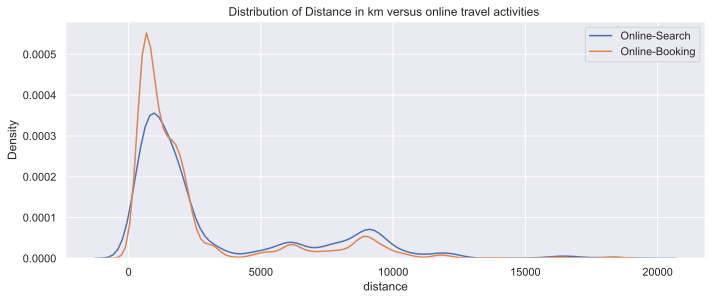

In [95]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['distance']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot when customer remained loyal
    sns.kdeplot(df_num.loc[df_num['event_type'] == "search", source], label = 'Online-Search')
    # plot when customers left 
    sns.kdeplot(df_num.loc[df_num['event_type'] == "book", source], label = 'Online-Booking')
    
    # Label the plots
    plt.title('Distribution of Distance in km versus online travel activities ')
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

We can see that for closer distances , there are more online activity. As usual, there are more instances of search than booking. This plot goes lower as we go along with distance which is as per data sanity.

**For ts_hour**

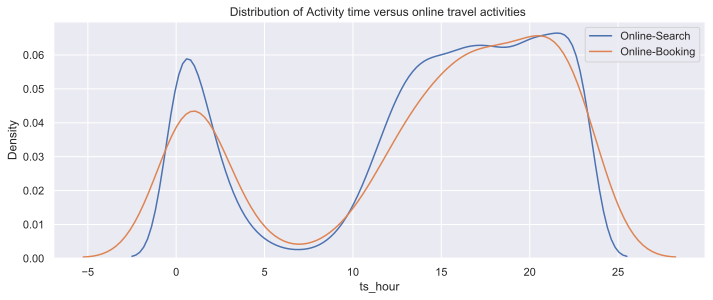

In [96]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['ts_hour']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot when customer remained loyal
    sns.kdeplot(df_num.loc[df_num['event_type'] == "search", source], label = 'Online-Search')
    # plot when customers left 
    sns.kdeplot(df_num.loc[df_num['event_type'] == "book", source], label = 'Online-Booking')
    
    # Label the plots
    plt.title('Distribution of Activity time versus online travel activities ')
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

This curve is pretty same as we looked in bar plot. It reaches at peak late at night i.e 23. Plot is as we have seen so far and is expected as per data sanity i.e more search activity and lower booking acitivity. Only there is a point around 19 where online booking crosses searching activities. Same is in lower activity time i.e 8 .

**For num_family**

In [97]:
fam_data=df_num[['event_type','num_family']]

In [98]:
fam_data.head()

,event_type,num_family
0,search,7
1,book,4
2,book,2
3,book,1
4,book,4


In [99]:
# Bin the data
fam_data['fam_bin'] = pd.cut(fam_data['num_family'], bins = np.linspace(0, 7, num = 8))
fam_data['event_type'] = fam_data.event_type.map({'search':0, 'book':1})
fam_data.head(5)

,event_type,num_family,fam_bin
0,0,7,"(6.0, 7.0]"
1,1,4,"(3.0, 4.0]"
2,1,2,"(1.0, 2.0]"
3,1,1,"(0.0, 1.0]"
4,1,4,"(3.0, 4.0]"


In [100]:
fam_groups = fam_data.groupby('fam_bin').mean()
fam_groups

,event_type,num_family
fam_bin,,
"(0.0, 1.0]",0.034326,1.0
"(1.0, 2.0]",0.049617,2.0
"(2.0, 3.0]",0.039568,3.0
"(3.0, 4.0]",0.035287,4.0
"(4.0, 5.0]",0.034409,5.0
"(5.0, 6.0]",0.037129,6.0
"(6.0, 7.0]",0.055556,7.0


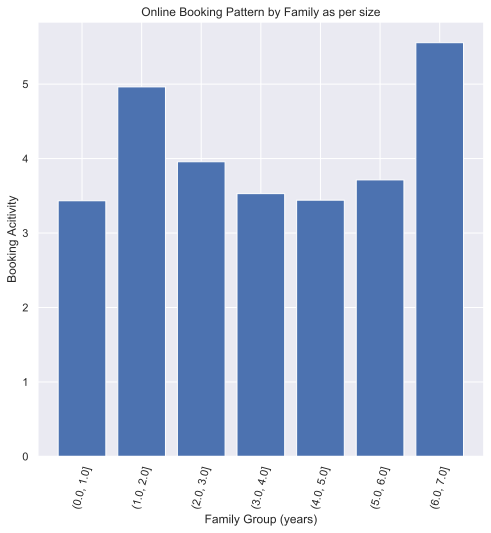

In [101]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(fam_groups.index.astype(str), 100 * (fam_groups['event_type']))

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Family Group (years)'); plt.ylabel('Booking Acitivity')
plt.title('Online Booking Pattern by Family as per size');

Surprisingly booking pattern for family 6-7 is highest. Very interesting 

### 5e. Check correlation

In [102]:
corr = df_num.corr()

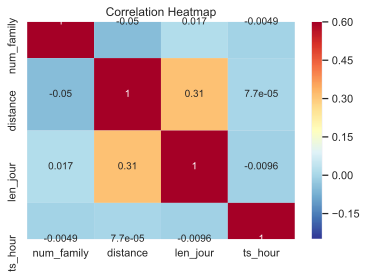

In [103]:
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Distance and journey length have a little correlation value.even this value is of no concern to me. For rest, we have a data with no correlation. For econometrics, it is good. It shows that our sample has less chance of biaseness.

### check VIF(Variance inflation factor)

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [105]:
df_travel.head()

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20
2,book,f953f0,BER,CGN,469.781624,2,2017-04-27 23:03:43,3.0,2017,4,27,3,23
3,book,794d35,BER,BCN,1498.817537,1,2017-04-27 15:17:50,3.0,2017,4,27,3,15
4,book,ca4f94,DEL,BKK,2921.339028,4,2017-04-27 22:51:57,6.0,2017,4,27,3,22


In [106]:
X_inspect=df_travel[["num_family","distance","len_jour","ts_hour"]]

In [107]:
X_inspect.head()

,num_family,distance,len_jour,ts_hour
0,7,5834.154716,6.0,11
1,4,6525.926149,21.0,20
2,2,469.781624,3.0,23
3,1,1498.817537,3.0,15
4,4,2921.339028,6.0,22


In [108]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_inspect.values, i) for i in range(X_inspect.shape[1])]
vif["features"] = X_inspect.columns

In [109]:
vif

,VIF Factor,features
0,2.356339,num_family
1,1.856006,distance
2,1.507805,len_jour
3,2.532113,ts_hour


All numeric features have lower VIF so, there is no issue of multi-colinearity with our numeric data part.

Value above 10 is point of concern according to literature.

### 5.f. Checking Outliers

**Tukey IQR**

Identifies extreme values in data Outliers are defined as:
- Values below Q1-1.5(Q3-Q1) or above Q3+1.5(Q3-Q1)
- Standard deviation from the mean is another common method to detect extreme values But it can be problematic:

- Assumes normality
- Sensitive to very extreme values

In [110]:
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [111]:
df_outlier=df_travel['distance']

In [112]:
tukey_indices, tukey_values = find_outliers_tukey(df_outlier)
print(np.sort(tukey_values))

[11900.12216409 11900.12216409 11900.12216409 ... 19050.56863301
 19052.75937704 19420.92494311]


In [113]:
df_travel['distance'].mean()

3232.925653181051

In [114]:
tukey_indices, tukey_values = find_outliers_tukey(df_travel['ts_hour'])
print(np.sort(tukey_values))

[]


In [115]:
tukey_indices, tukey_values = find_outliers_tukey(df_travel['num_family'])
print(np.sort(tukey_values))

[4 4 4 ... 9 9 9]


In [116]:
df_travel['num_family'].mean()

1.821526034275734

even for such a value with mean 1.82 outlier threshold is strict. We have 4 and 9 which are considered as outliers. We need to make sense for ourselves if we have outlier problem with 4 and 9 in family size.

Earlier we checked that higher family size makes more booking. So, we won't be alarmed by this higher number. Another point to this. Perhaps two families are joined together for travel and that's why this number is higher upto 9.

We need to know if they have any suspected variables with such issues.For now, only seriously over-burdened variable is "distance". We will fix them in next section before feeding to model

# 6)- Data preparation for Model

In [117]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


### 6.1)-Drop Extra variables

Reason to drop these variables is discussed above. Some of them are related to time stamp and since I have taken ts_hour , we do not need them.
user_id is dropped because it will not give much information for predictive analysis. If we had a case where we do user profiling then this might be useful. I have provided descriptive analysis for "user_id" variable as well 

In [118]:
df_travel.drop(['user_id','ts_datetime', 'ts_year','ts_month','ts_day','ts_dayofweek'], axis=1, inplace=True)

In [119]:
df_travel.shape

(45805, 7)

In [120]:
df_travel.head(2)

,event_type,origin,destination,distance,num_family,len_jour,ts_hour
0,search,PAR,NYC,5834.154716,7,6.0,11
1,book,FRA,WAS,6525.926149,4,21.0,20


### 6.2)- Encode Target variable

I ll use simple map() function. There are other techniques like one-hot encoding which are also used. Outcome is same pretty much.

In [121]:
df_travel['event_type'] = df_travel.event_type.map({'search':0, 'book':1})

In [122]:
df_travel.head(2)

,event_type,origin,destination,distance,num_family,len_jour,ts_hour
0,0,PAR,NYC,5834.154716,7,6.0,11
1,1,FRA,WAS,6525.926149,4,21.0,20


### 6.3)- Encode Categorical variables

origin and destination

In [123]:
pd.get_dummies(df_travel['origin']).iloc[:,1:].head()

,ADB,ADL,AER,AGP,AKL,ALA,ALC,ALG,AMS,ANK,...,YEA,YMQ,YOW,YTO,YUL,YVR,YWG,YYC,YYZ,ZRH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that encoding has created a unique identifier for each airport origin

In [124]:
origin_dummy=pd.get_dummies(df_travel['origin'],prefix='origin').iloc[:,1:]
df_travel=pd.concat([df_travel,origin_dummy],axis=1)
df_travel.shape

(45805, 242)

In [125]:
df_travel.head(2)

,event_type,origin,destination,distance,num_family,len_jour,ts_hour,origin_ADB,origin_ADL,origin_AER,...,origin_YEA,origin_YMQ,origin_YOW,origin_YTO,origin_YUL,origin_YVR,origin_YWG,origin_YYC,origin_YYZ,origin_ZRH
0,0,PAR,NYC,5834.154716,7,6.0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,FRA,WAS,6525.926149,4,21.0,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Same procedure for destination variable**

In [126]:
pd.get_dummies(df_travel['destination']).iloc[:,1:].head(2)

,ADB,ADD,ADL,AER,AGP,AKL,ALA,ALC,ALG,AMS,...,YEG,YMQ,YOW,YTO,YUL,YVR,YWG,YYC,YYZ,ZRH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
dest_dummy=pd.get_dummies(df_travel['destination'],prefix='dest').iloc[:,1:]
df_travel=pd.concat([df_travel,dest_dummy],axis=1)
df_travel.shape

(45805, 517)

**drop origin and destination variables as they have converted to their dummies**

In [128]:
df_travel.drop(['origin','destination'], axis=1, inplace=True)

In [129]:
df_travel.head(2)

,event_type,distance,num_family,len_jour,ts_hour,origin_ADB,origin_ADL,origin_AER,origin_AGP,origin_AKL,...,dest_YEG,dest_YMQ,dest_YOW,dest_YTO,dest_YUL,dest_YVR,dest_YWG,dest_YYC,dest_YYZ,dest_ZRH
0,0,5834.154716,7,6.0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6525.926149,4,21.0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 7)- Saving data file

In [130]:
df_travel.to_csv('selected_feature.csv',index=False)

There could be an arguement that we should only keep the variables that are important for our predictive model. I will show in next book why I kept these variables, what are the most significant variables. For categorical variables, these are not like numeric. We do not need to worry about this increase in column size as far as they provide interesting results. 

In descriptive analysis, origin and destination features have shown interesting insight for our online booking and search activities. That is why I shall keep both of their impact in equation.

**END OF NOTEBOOK2**